<a href="https://colab.research.google.com/github/ast-abo/ShotTracker/blob/master/ShotTrackerModelTraingScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow
from roboflow import Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/107.7 GB disk)


In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 65.7MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 66.9k/66.9k [00:00<00:00, 171kB/s]
image 1/1 /content/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg: 640x448 1 person, 1 clock, 291.0ms
Speed: 16.3ms preprocess, 291.0ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


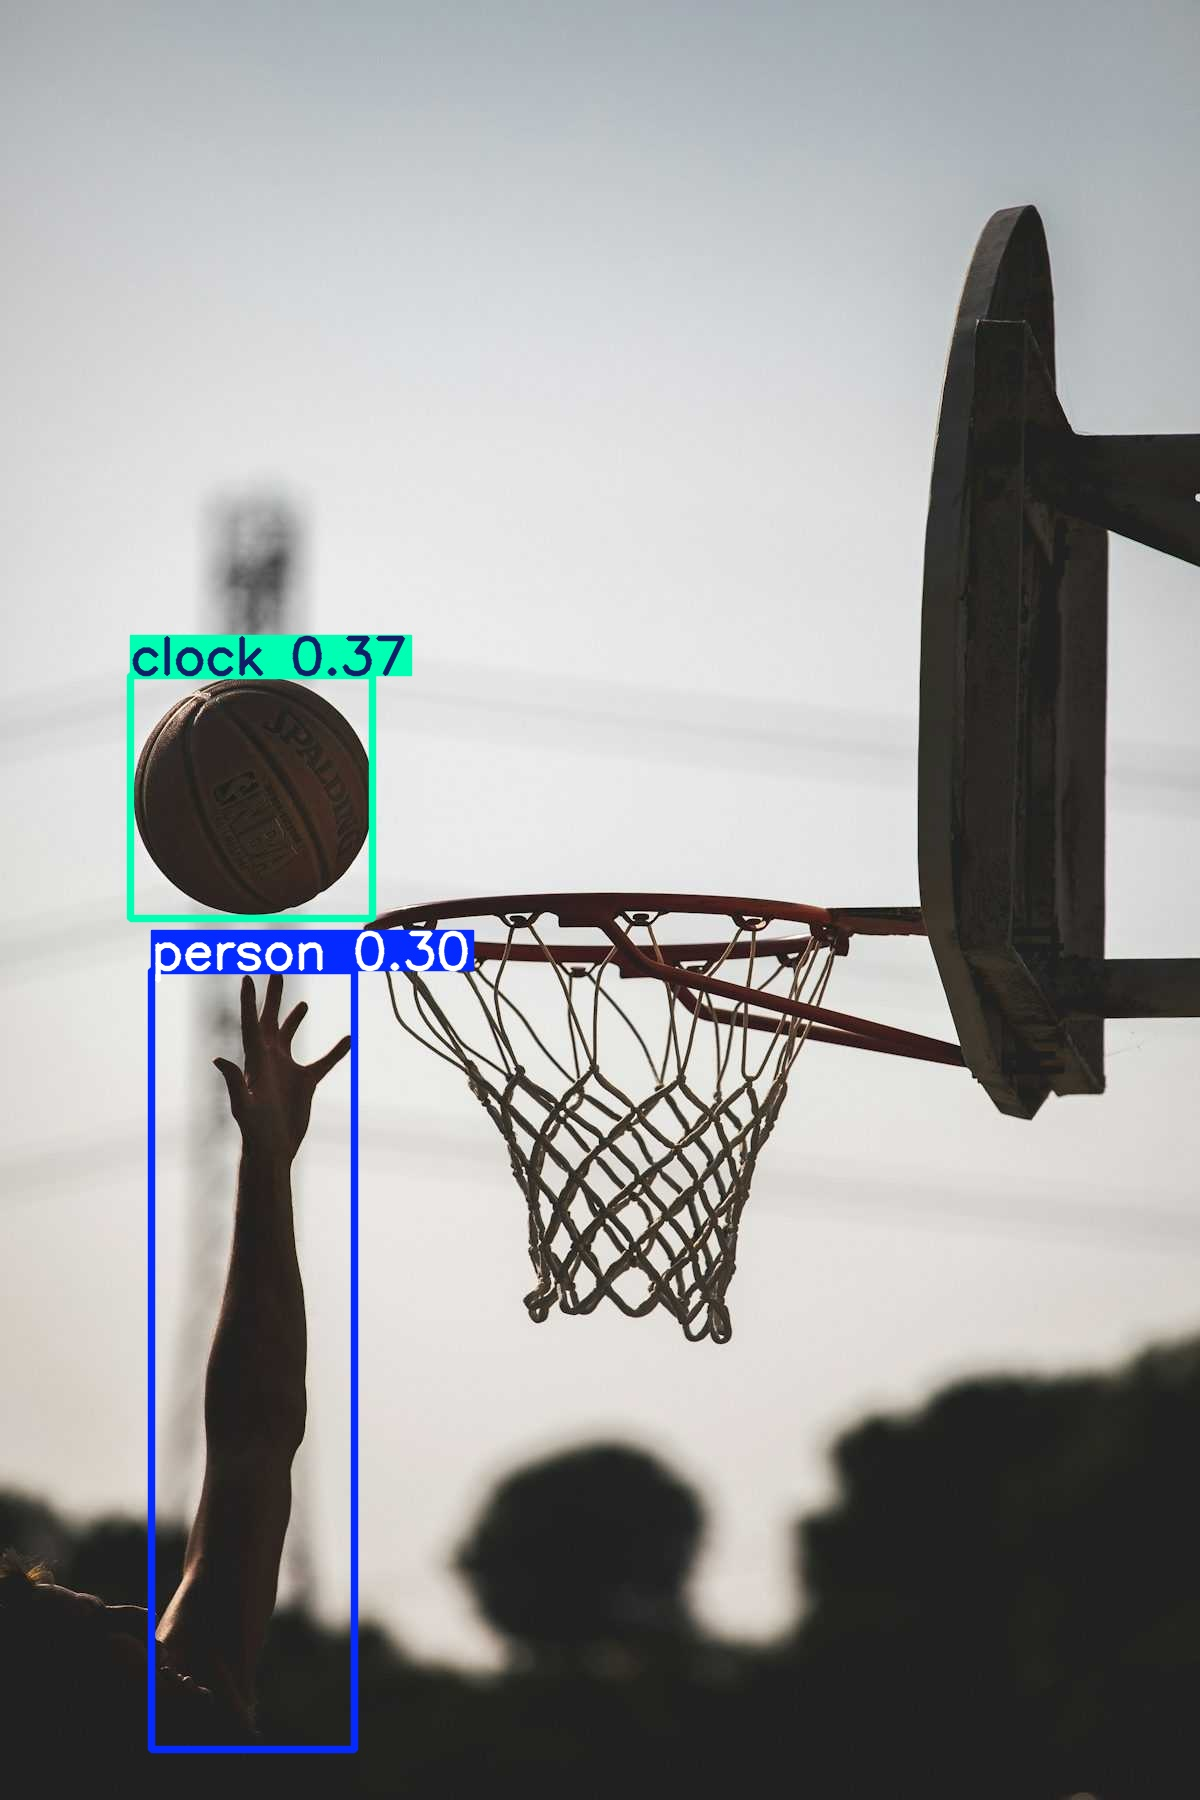

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/ball.jpg', width=600)

In [7]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x448 1 person, 1 clock, 185.3ms
Speed: 5.9ms preprocess, 185.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


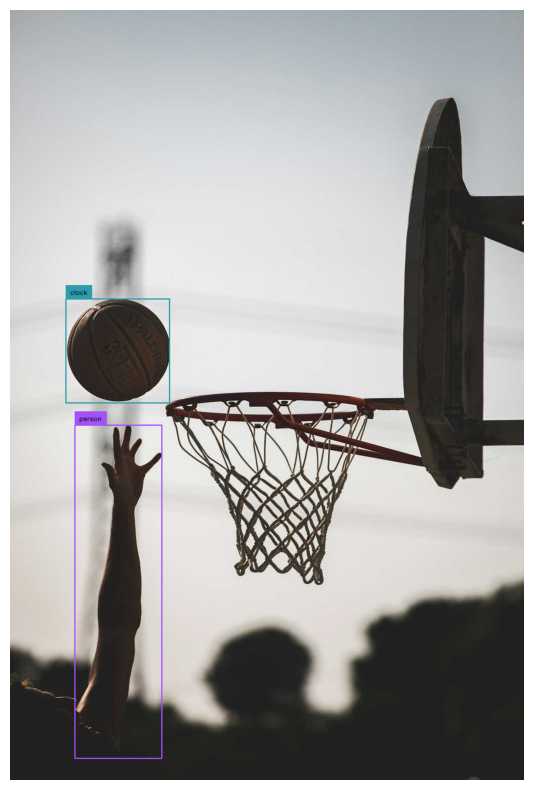

In [8]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)


sv.plot_image(annotated_image, size=(10, 10))

In [9]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="NLWnQPigGaE8pl98gFYh")
project = rf.workspace("icespace").project("shot-tracker-ik6bf")
version = project.version(2)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Shot-Tracker-2 in yolov11:: 100%|██████████| 52/52 [00:00<00:00, 4668.62it/s]


In [10]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 137MB/s] 
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Shot-Tracker-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

In [11]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png
confusion_matrix_normalized.png			    results.csv
confusion_matrix.png				    results.png
events.out.tfevents.1745867325.abf01efb6beb.1308.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    val_batch0_labels.jpg
P_curve.png					    val_batch0_pred.jpg
PR_curve.png					    weights


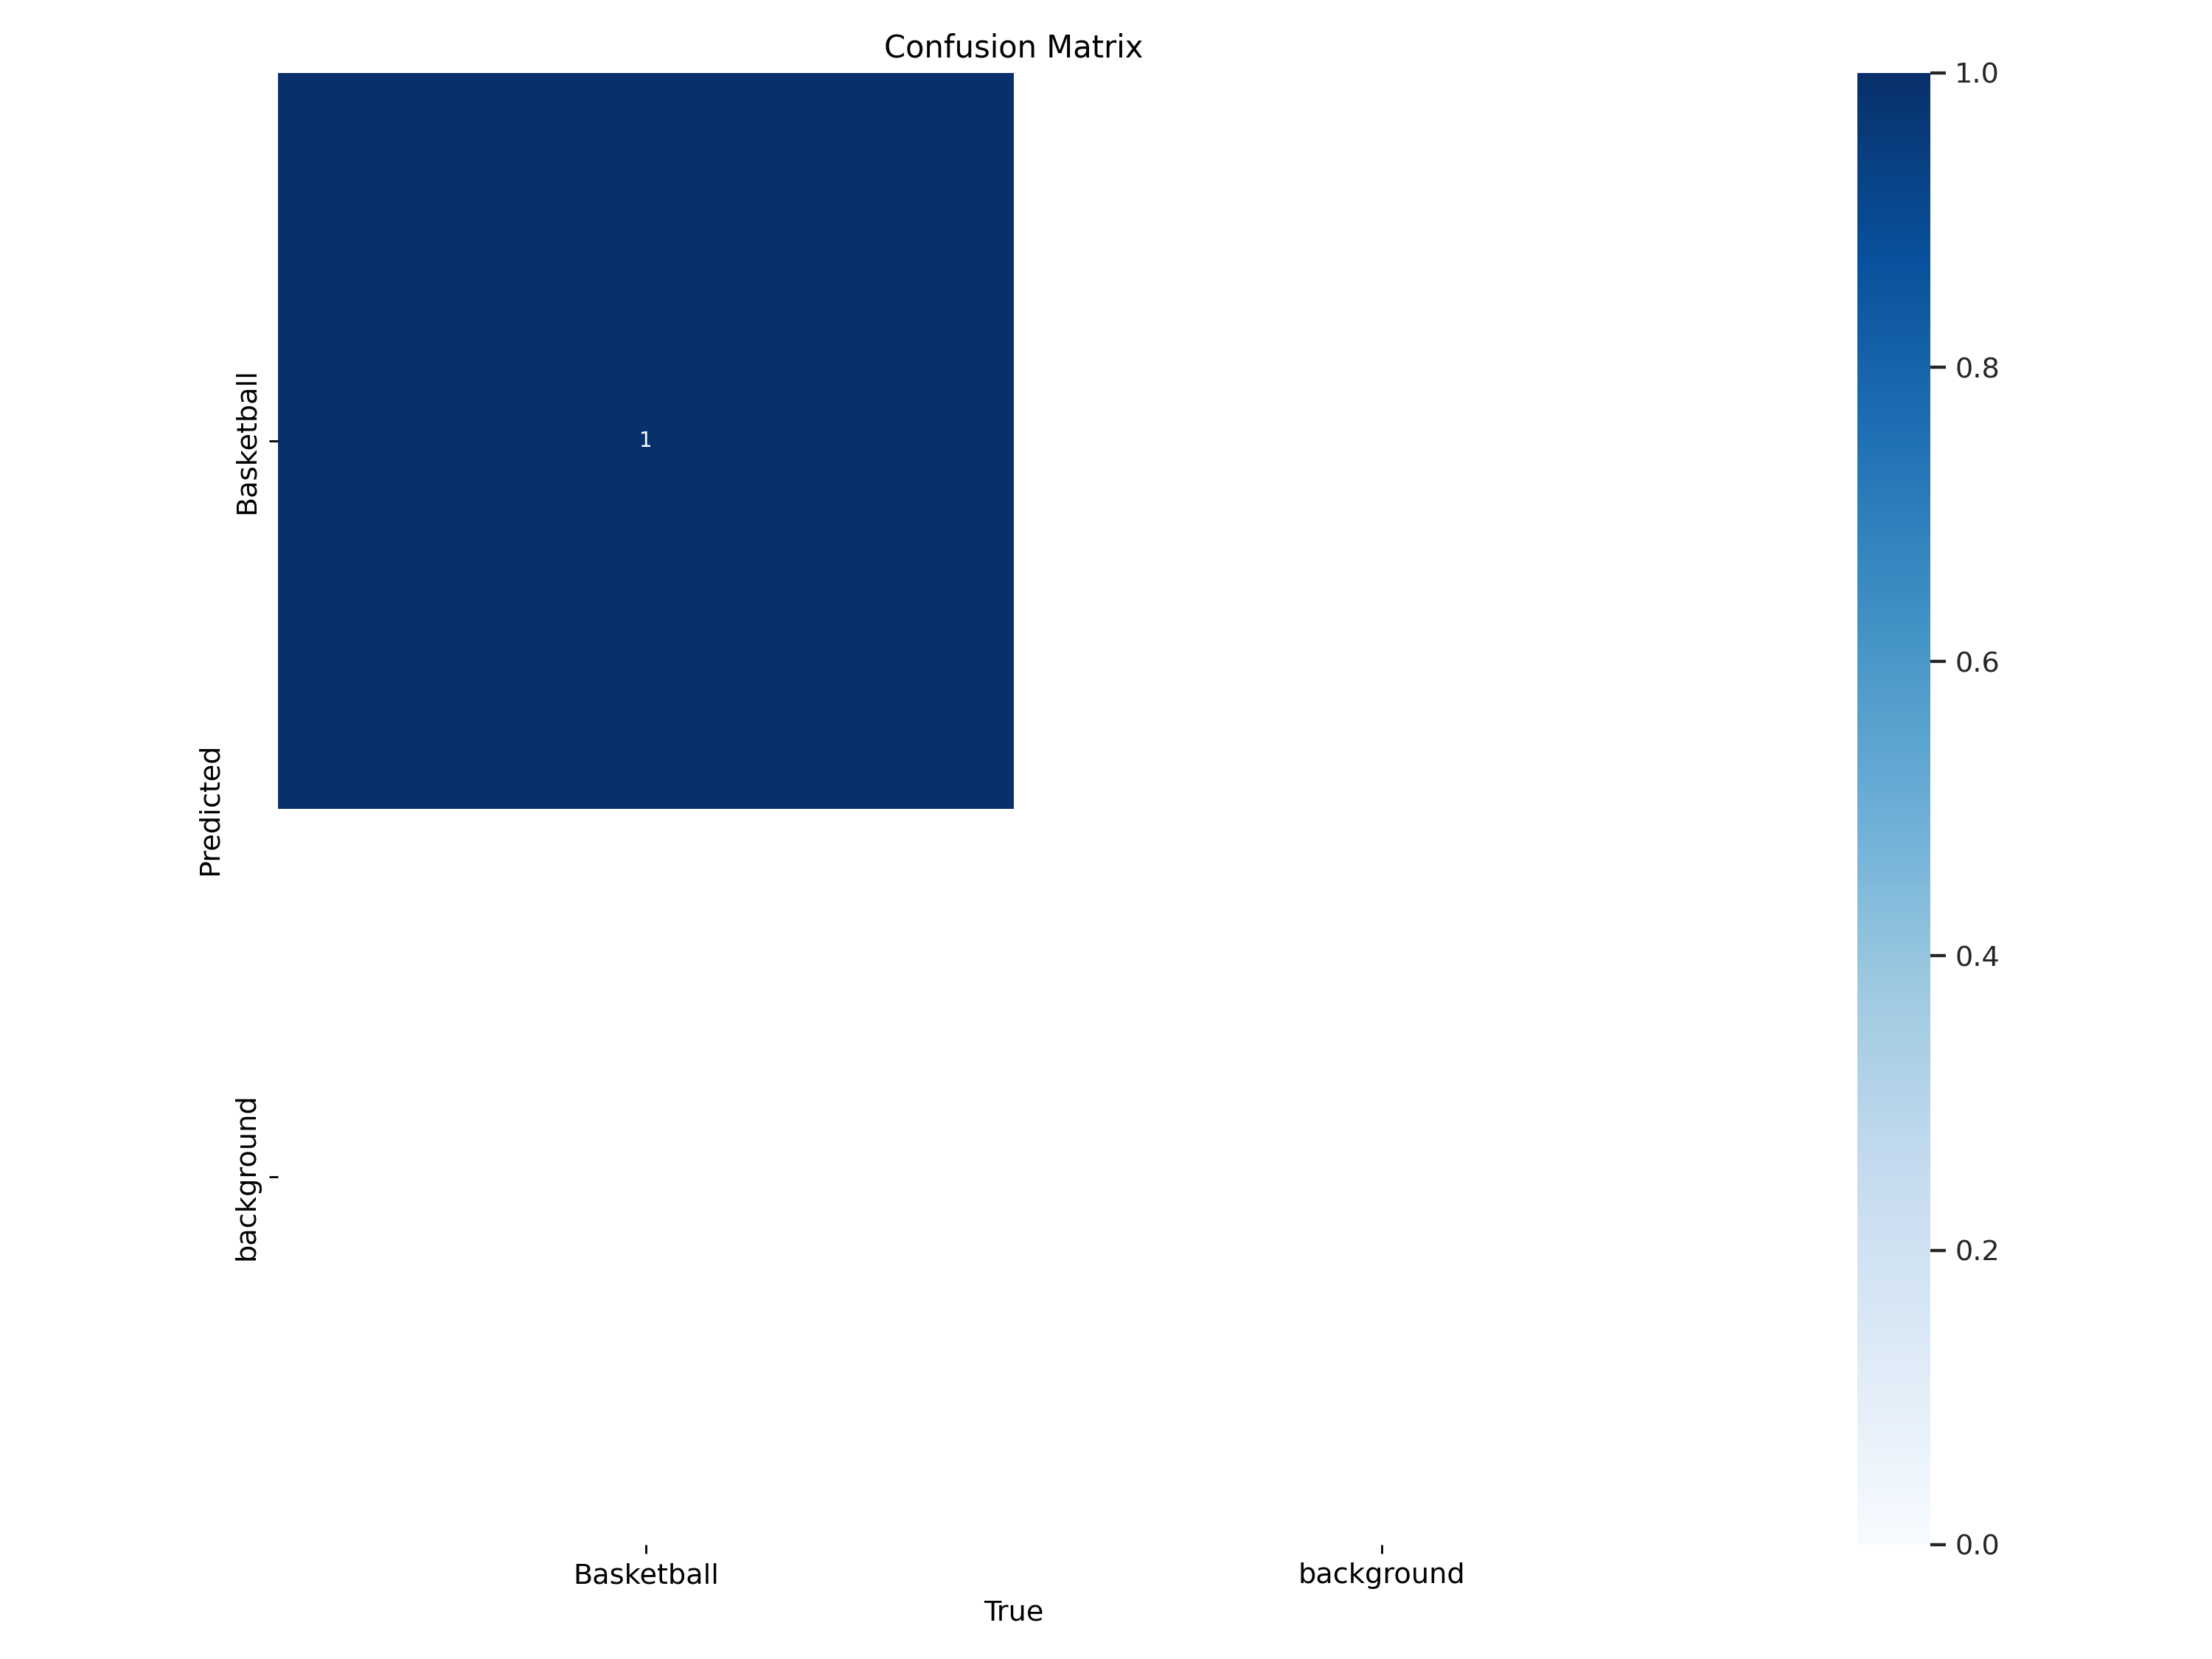

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

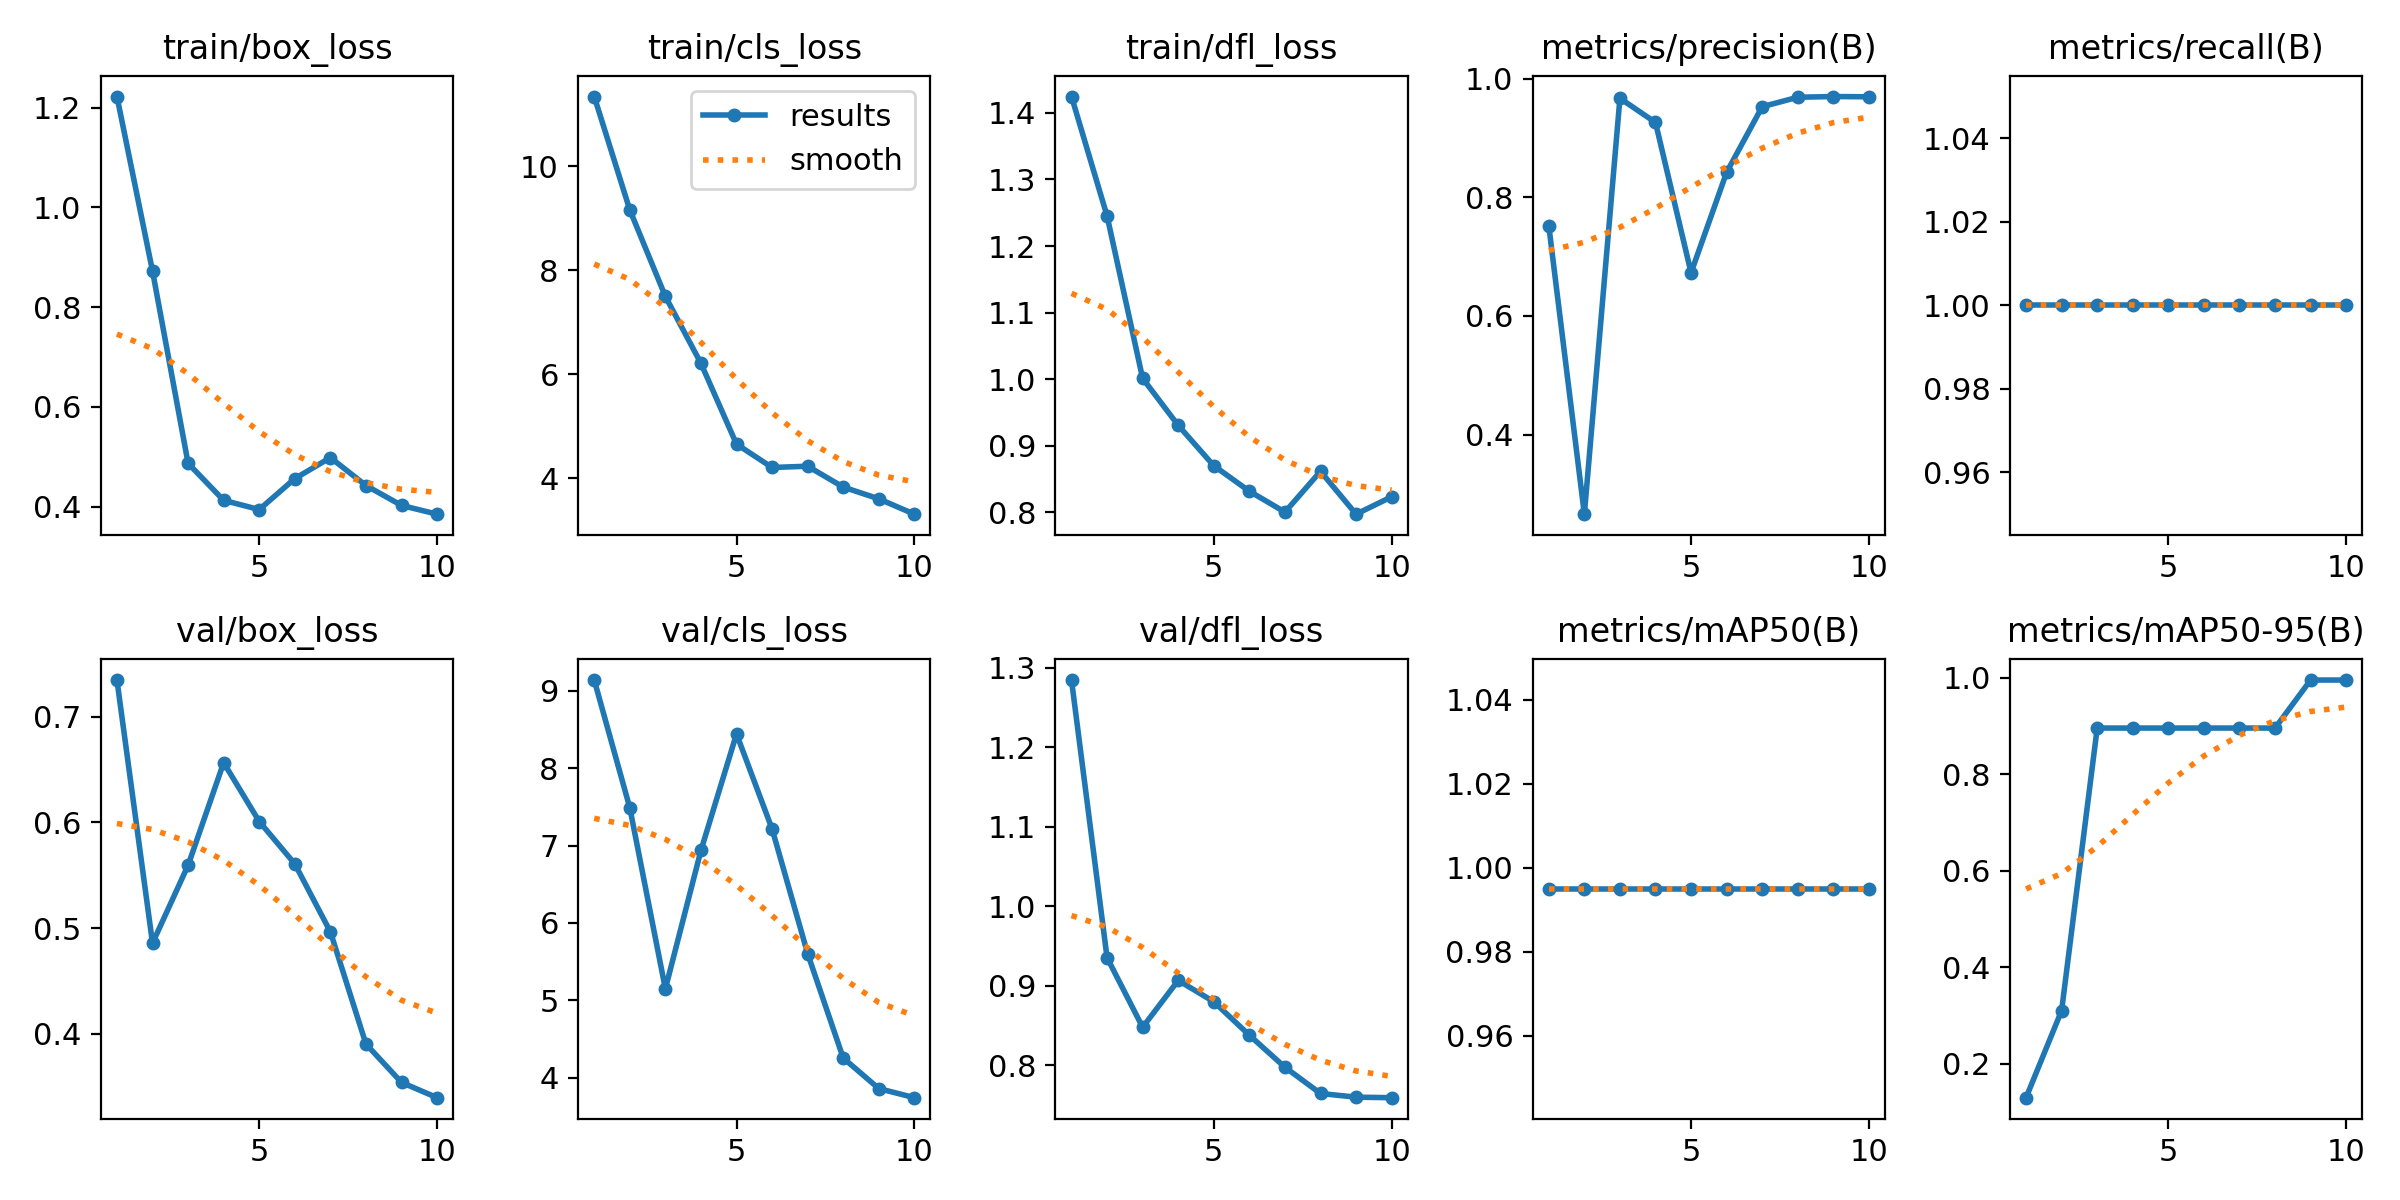

In [13]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

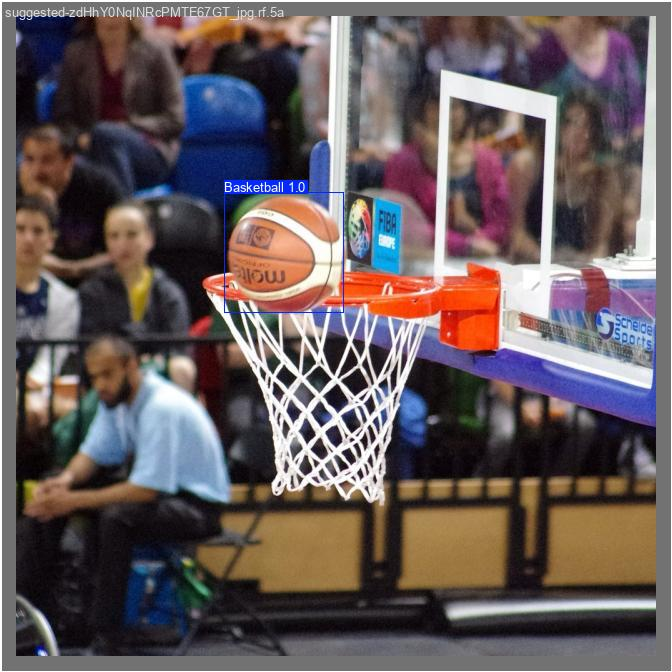

In [14]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [16]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Shot-Tracker-2/valid/labels.cache... 1 images, 0 backgrounds, 0 corrupt: 100% 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.33it/s]
                   all          1          1      0.969          1      0.995      0.995
Speed: 10.2ms preprocess, 657.2ms inference, 0.0ms loss, 70.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [19]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

View the status of your deployment at: https://app.roboflow.com/icespace/shot-tracker-ik6bf/2
Share your model with the world at: https://universe.roboflow.com/icespace/shot-tracker-ik6bf/model/2


In [4]:
!pip install inference

['.ipynb_checkpoints', 'img.rf.e6aa4bff9f99c3b197c11a6d7d165961.jpg']
Running inference on img.rf.e6aa4bff9f99c3b197c11a6d7d165961.jpg


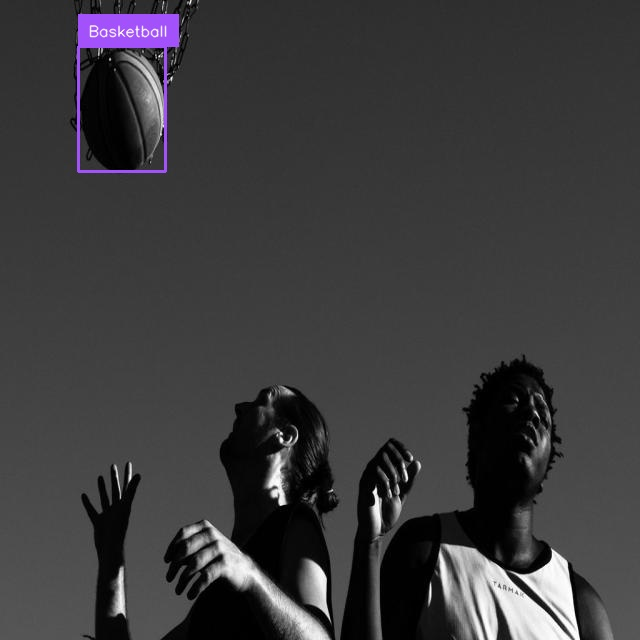

In [23]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = 'shot-tracker-ik6bf/2'
model = inference.get_model(model_id, 'NLWnQPigGaE8pl98gFYh')

# Location of test set images
test_set_loc = '/content/datasets/Shot-Tracker-2/test/images'
test_images = os.listdir(test_set_loc)
print(test_images)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))
    if image is None:
      continue

    print("Running inference on " + img_name)

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
